In [227]:
import pandas as pd
import numpy as np
import string
import re
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from bs4 import BeautifulSoup
import emoji


from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix


import seaborn as sns
import matplotlib.pyplot as plt


from nltk.corpus import stopwords
from nltk.corpus import wordnet 

from sklearn.feature_extraction.text import TfidfVectorizer


from collections import Counter

from io import StringIO



In [932]:
class Classifier:
    
    def split_data(self,X, Y, percentage=0.8):
        """
         Split the training data into training and test set according to given percentage... 

        Parameters:
        --------
        X: training examples
        Y: training labels
        percentage: split data into train and test accorind to given %

        Returns:
        ---------    
        returns four lists as tuple: training data, training labels, test data, test labels 
        """

        testp=1-percentage

        #Split the data into train and test according to given fraction..

        #Creat a list of tuples according to the n-classes where each tuple will 
        # contain the pair of training and test examples for that class...
        #each tuple=(training-examples, training-labels,testing-examples,testing-labels)
        exdata=[]
        #Creat 4 different lists 
        traindata=[]
        trainlabels=[]
        testdata=[]
        testlabels=[]

        classes=np.unique(Y)

        for c in classes:
            # print c
            idx=Y==c
            Yt=Y[idx]
            Xt=X[idx,:]
            nexamples=Xt.shape[0]
            # Generate a random permutation of the indeces
            ridx=np.arange(nexamples) # generate indeces
            np.random.shuffle(ridx)
            ntrainex=round(nexamples*percentage)
            ntestex=nexamples-ntrainex

            ntrainex = int(ntrainex)

            traindata.append(Xt[ridx[:ntrainex],:])
            trainlabels.append(Yt[ridx[:ntrainex]])

            testdata.append(Xt[ridx[ntrainex:],:])
            testlabels.append(Yt[ridx[ntrainex:]])

            #exdata.append((Xt[ridx[:ntrainex],:], Yt[ridx[:ntrainex]], Xt[ridx[ntrainex:],:], Yt[ridx[ntrainex:]]))


        # print traindata,trainlabels
        Xtrain=np.concatenate(traindata)
        Ytrain=np.concatenate(trainlabels)
        Xtest=np.concatenate(testdata)
        Ytest=np.concatenate(testlabels)
        return Xtrain, Ytrain, Xtest, Ytest
    
    def loadData(self, filename,_sep='\t'):
        self.data = pd.read_csv(filename,sep=_sep)
    
    def removeDuplicatesColumns(self):
        self.data   = self.data.drop_duplicates(subset='tweet_id')
        self.t_data = self.data[['text','sentiment','tweet_id']]
    
    def split(self):
        
        x = self.t_data["text"].values
        X = x.reshape((x.shape[0],1))
        Y = np.array(self.t_data['sentiment'])
        Xtrain, Ytrain, Xtest, Ytest = self.split_data(X,Y)
        
        
        train=pd.DataFrame(Xtrain,columns=['text'])
        train['sentiment']=Ytrain
        self.train=train
        
        test=pd.DataFrame(Xtest,columns=['text'])
        test['sentiment']=Ytest
        self.test=test
        
    def mark_neg(self, tweet):
        
        tk=nltk.casual.TweetTokenizer()
        doc=tk.tokenize(tweet)
        pos=nltk.pos_tag(doc)


        flag=False

        for i in range(0, len(pos)-2):
            if (pos[i][0]=='not' or ("n't" in pos[i][0]) or pos[i][0]=="no"):
                #print ('oye hoye0')
                flag = not flag
            if flag==True:
                #if (pos[i][1]=='JJ' or pos[i][1]=='JJR' or pos[i][1]=='JJS') or (pos[i][1]=='VB' or pos[i][1]=='VBD' or pos[i][1]=='VBG' or pos[i][1]=='VBN' or pos[i][1]=='VBP' or pos[i][1]=='VBZ') or (pos[i][1]=='NN' or pos[i][1]=='NNS' or pos[i][1]=='NNP' or pos[i][1]=='NNPS'):
                    #print ('oye hoye1')
                #    doc[i]='_'.join(['not',doc[i]])
                if ((pos[i][1]=='RB' or pos[i][1]=='RBR' or pos[i][1]=='RBS') or pos[i][1]=='DT') and (pos[i+1][1]=='JJ' or pos[i+1][1]=='JJR' or pos[i+1][1]=='JJS'):
                    #print ('oye hoye2')
                    doc[i+1]='_'.join(['not',doc[i+1]])
                    
                if pos[i][1]=='DT' and (pos[i+1][1]=='RB' or pos[i+1][1]=='RBR' or pos[i+1][1]=='RBS') and (pos[i+2][1]=='JJ' or pos[i+2][1]=='JJR' or pos[i+2][1]=='JJS'):
                    #print ('oye hoye3')
                    doc[i+2]='_'.join(['not',doc[i+2]])
                
                flag=False

        return ' '.join(doc)
    
    def custom_mark_neg(self, tweet):
        
        tk=nltk.casual.TweetTokenizer()
        doc=tk.tokenize(tweet)
        pos=nltk.pos_tag(doc)


        flag=False

        for i in range(0, len(pos)):
            if (pos[i][0]=='not' or ("n't" in pos[i][0]) or pos[i][0]=="no"):
                #print ('oye hoye0')
                flag = not flag
            if flag==True:
                
                if i+1<len(pos):
                    if pos[i+1][1]=='JJ' or pos[i+1][1]=='JJR' or pos[i+1][1]=='JJS':
                        #doc[i+1]='_'.join(['not',doc[i+1]])
                        doc[i+1]=getAntonym(doc[i+1])
                        doc[i]=''
                    elif ((pos[i][1]=='RB' or pos[i][1]=='RBR' or pos[i][1]=='RBS') or pos[i][1]=='DT') and (pos[i+1][1]=='JJ' or pos[i+1][1]=='JJR' or pos[i+1][1]=='JJS'):
                        #doc[i+1]='_'.join(['not',doc[i+1]])
                        doc[i+1]=getAntonym(doc[i+1])
                        doc[i]=''
                elif i+2<len(pos):
                    if pos[i+2][1]=='JJ' or pos[i+2][1]=='JJR' or pos[i+2][1]=='JJS':
                        #doc[i+2]='_'.join(['not',doc[i+2]])
                        doc[i+2]=getAntonym(doc[i+2])
                        doc[i]=''
                    elif pos[i][1]=='DT' and (pos[i+1][1]=='RB' or pos[i+1][1]=='RBR' or pos[i+1][1]=='RBS') and (pos[i+2][1]=='JJ' or pos[i+2][1]=='JJR' or pos[i+2][1]=='JJS'):
                        #doc[i+2]='_'.join(['not',doc[i+2]])
                        doc[i+2]=getAntonym(doc[i+2])
                        doc[i]=''
                elif i+3<len(pos):
                    if pos[i+3][1]=='JJ' or pos[i+3][1]=='JJR' or pos[i+3][1]=='JJS':
                        #doc[i+3]='_'.join(['not',doc[i+3]])
                        doc[i+3]=getAntonym(doc[i+3])
                        doc[i]=''
                elif i+4<len(pos):
                    if pos[i+4][1]=='JJ' or pos[i+4][1]=='JJR' or pos[i+4][1]=='JJS':
                        #doc[i+4]='_'.join(['not',doc[i+4]])
                        doc[i+4]=getAntonym(doc[i+4])
                        doc[i]=''
               
                
                flag=False

        return ' '.join(doc)        
        
        
    def give_emoji_free_text(self, text):
        allchars   = [str for str in text]
        emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
        clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])

        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U0001F1F2-\U0001F1F4"  # Macau flag
            u"\U0001F1E6-\U0001F1FF"  # flags
            u"\U0001F600-\U0001F64F"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U0001F1F2"
            u"\U0001F1F4"
            u"\U0001F620"
            u"\u200d"
            u"\u2640-\u2642"
            "]+", flags=re.UNICODE)

        clean_text = emoji_pattern.sub(r'', clean_text)

        return clean_text

    def preProcessingSubfunction(self, tweet):
        tweet=tweet.encode().decode("utf-8-sig")
        tweet=tweet.replace(u"\ufffd", "?")
        tweet=tweet.replace(u"\\u002c","")
        tweet=re.sub('\s+', ' ', tweet)
        
        tweet=re.sub(r'[0-9]+(th|nd|st|rd)','',tweet)
        
        tweet=re.sub('@[A-Za-z0-9_]+|https?://[^ ]+|^(RT )|( RT )', ' ', tweet)
        tweet=re.sub('www.[^ ]+', ' ', tweet)
        tweet=BeautifulSoup(tweet, 'lxml').get_text().lower()
        tweet=re.sub(r"""["\?,$!@#\-$\\%\^&*()\[\]{}`“\/~\|._\+\-;<>=:]|'(?!(?<! ')[ts])""", "", tweet)
        #tweet=self.give_emoji_free_text(tweet)
        tweet = apostrapheHandler(tweet)
        #hash removal STARTS
        #tweet=re.sub(r'#[a-z0-9]*','',tweet)
        #hash removal ENDS
        
        #acronyms STARTS
        tweet = re.sub(r'(.)\1+', r'\1\1', tweet)   
        tweet = self.acronymHandler(tweet)
        #acronyms ENDS
        
        tweet=re.sub(r"[0-9]","",tweet)
        
        #tweet=" ".join(mark_negation(tweet.split()))
        #tweet=self.mark_neg(tweet)
        tweet=self.custom_mark_neg(tweet)
        
        return tweet
 
    def acronymHandler(self, tweet):
        tokenizer = nltk.casual.TweetTokenizer()
        tweetArr = tokenizer.tokenize(tweet)
        for i in range(len(tweetArr)):
            #print(tweetArr[i])
            if tweetArr[i] in self.acrDict:
                tweetArr[i] = self.acrDict[tweetArr[i]]
        
    
        tweet = ' '.join(tweetArr)
        return tweet
    
    def makeAcronymDictionary(self,filename):
        acrData = pd.read_csv(filename,sep="\t")
        acrData = acrData.apply(lambda x: x.astype(str).str.lower())
        self.acrDict = dict(zip(acrData.acronym, acrData.definition))

    def preProcessing(self):
        self.makeAcronymDictionary("acronyms.txt")
        self.train['processed_text'] = self.train['text'].apply(lambda x: self.preProcessingSubfunction(x))
        self.test ['processed_text'] = self.test['text'].apply(lambda x: self.preProcessingSubfunction(x))
    
    def align(self, arr=['text','processed_text','sentiment']):
        self.train=self.train[arr]
        self.test =self.test[arr]
    
    def targetDomain(self):
        return list(np.unique(self.train['sentiment']))
    
    def testLabels(self):
        return list(self.test['sentiment'])
    
    def underSampling(self):
        
        cnames=['Positive','Negative','Neutral']
        classes=set([0,1,2])
        PosNegNeu=[(sum(self.t_data['sentiment']=='Positive')),(sum(self.t_data['sentiment']=='Negative')),(sum(self.t_data['sentiment']=='Neutral'))]
        minone=np.argmin(PosNegNeu)


        new_t_data = self.t_data[(self.t_data['sentiment']==cnames[minone])]

        classes=classes-set([minone])
        for _class in classes:
            _class_indices = self.t_data[self.t_data.sentiment == cnames[_class]].index
            random_indices = np.random.choice(_class_indices, sum(self.t_data['sentiment']==cnames[minone]), replace=False)
            _class_sample  = self.t_data.loc[random_indices]

            new_t_data = pd.concat([new_t_data, _class_sample], ignore_index=True)

        self.t_data=new_t_data
        self.t_data=self.t_data.sample(frac=1).reset_index(drop=True)
    
  
    def train_classifier(self, tokenizer=nltk.casual.TweetTokenizer(),vectorizer=CountVectorizer(),mindif=2,mfeatures=None,stopwords=None,classifier=MultinomialNB(),ngramRng=(1,1)):
        # initialize tweet_vector object, and then turn tweet train data into a vector 
        self.tokenizer  = tokenizer
        self.vectorizer = vectorizer        
        self.vectorizer.set_params(min_df=mindif, tokenizer=self.tokenizer.tokenize,max_features=mfeatures, stop_words=stopwords,ngram_range=ngramRng)

        self.train_tweet_counts = self.vectorizer.fit_transform(self.train['processed_text'])
        self.classifier = classifier.fit(self.train_tweet_counts, list(self.train['sentiment']))

    def predict(self):
        
        test_tweet_counts = self.vectorizer.transform(self.test['processed_text'])
        return self.classifier.predict(test_tweet_counts)
        
def printings():
    labels = naivebayes.targetDomain()
    conmat = np.array(confusion_matrix(naivebayes.testLabels(), y_pred, labels=labels))
    confusion = pd.DataFrame(conmat, index=labels,
                             columns=['predicted_'+x for x in labels])
    print ("\n")
    print ("Accuracy Score: {0:.2f}%".format(accuracy_score(naivebayes.testLabels(), y_pred)*100))
    print ("-"*80)
    print ("Confusion Matrix\n")
    print (confusion)
    print ("-"*80)
    print ("Classification Report\n")
    print (classification_report(naivebayes.testLabels(), y_pred,digits=5))

def getCustomStopWords():
    stopWords=set(stopwords.words('english'))

    _stopWords=[]
    for x in stopWords:
        if "'" not in x:
            _stopWords.append(x)
    return _stopWords

def getCustomStopWords3():
    stopWords=set(stopwords.words('english'))
    li=[]

    oldValue=report_to_df(classification_report(naivebayes.testLabels(), y_pred,digits=20))['f1-score']['avg/total']

    for a in stopWords:
        fake=li.copy()
        fake.append(a)

        naivebayes.train_classifier(stopwords=set(fake),mindif=3,ngramRng=(1,5),vectorizer=TfidfVectorizer())
        y_pred = naivebayes.predict()

        newValue=report_to_df(classification_report(naivebayes.testLabels(), y_pred,digits=20))['f1-score']['avg/total']
   
        if oldValue < newValue:
            li.append(a)
            oldValue=newValue
            
    return li


def getCustomStopWords2():
    stopWords=set(stopwords.words('english'))

    _stopWords=[]
    for x in stopWords:
        if "not" in x or "n't" in x or "no" in x:
            _stopWords.append(x)
    return _stopWords

def apostrapheHandler(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)
    phrase = re.sub(r"shan\'t", "shall not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def report_to_df(report):
    report = re.sub(r" +", " ", report).replace("avg / total", "avg/total").replace("\n ", "\n")
    report_df = pd.read_csv(StringIO("Classes" + report), sep=' ', index_col=0)        
    return(report_df)

def getAntonym(word):

    customDict={'alive':'dead',

    'backward':'forward',

    'beautiful':'ugly',

    'big':'small',

    'blunt':'sharp',

    'boring':'interesting',

    'bright' :'dark' ,

    'broad':'narrow',

    'clean':'dirty',

    'intelligent':'stupid',

    'closed':'open',

    'cool':'warm',

    'cruel':'kind',

    'dangerous':'safe',



    'deep':'shallow',

    'difficult':'easy',

    'dry':'wet',

    'early':'late',

    'fake':'real',

    'fast':'slow',

    'fat':'thin',

    'gentle':'fierce',

    'good':'bad',

    'happy':'sad',

    'hard':'soft',

    'heavy':'light' ,

    'high':'low',

    'hot':'cold',

    'ill':'well',

    'innocent':'guilty',

    'long' :'short' ,

    'loose':'tight',

    'loud' :'soft' ,

    'low':'high',

    'modern':'ancient',

    'noisy':'quiet',

    'normal':'strange',

    'old' :'new' ,

    'outgoing':'shy',

    'poor':'rich',

    'right' :'wrong',


    'rough':'smooth',

    'short' :'tall' ,

    'sour':'sweet',

    'strong':'weak',

    'terrible':'wonderful',

    'far':'near',

    'cheap':'expensive',
    
    'ok':'disapprove'
            
    }
    
    if word in customDict.keys():
        return customDict[word]
    else:
        antonyms = [] 

        
        for syn in wordnet.synsets(word): 
            for l in syn.lemmas(): 
                if l.antonyms(): 
                    antonyms.append(l.antonyms()[0].name()) 


        counter=Counter(antonyms) 
        if len(counter)>=1:
            return counter.most_common(1)[0][0]
        else:
            return word

# Read Data

In [933]:
naivebayes = Classifier()
naivebayes.loadData('Custom.csv')

In [720]:
naivebayes.data.head()

,Unnamed: 0,sentiment,text,tweet_id
0,0,Neutral,This time NEXT SATURDAY NIGHT we will be about...,224057065746862080
1,1,Negative,Notes on the Republican Debate (gibberish) htt...,629674653947047936
2,2,Positive,"Moving out by January and buying a new Lexus, ...",637375640472190976
3,3,Neutral,Starting to make our wicker lanterns today fo...,255225557673967616
4,4,Neutral,"Every time the debate bell rings, my dogs frea...",629479907807129600


In [934]:
naivebayes.data=naivebayes.data[~naivebayes.data['text'].apply(lambda x: (('neutral' in x) or ('positive' in x) or ('negative' in x)) and (len(x) > 140) )]

# Removing duplicates and dropping columns

In [935]:
naivebayes.removeDuplicatesColumns()
naivebayes.t_data.head()

,text,sentiment,tweet_id
0,This time NEXT SATURDAY NIGHT we will be about...,Neutral,224057065746862080
1,Notes on the Republican Debate (gibberish) htt...,Negative,629674653947047936
2,"Moving out by January and buying a new Lexus, ...",Positive,637375640472190976
3,Starting to make our wicker lanterns today fo...,Neutral,255225557673967616
4,"Every time the debate bell rings, my dogs frea...",Neutral,629479907807129600


In [697]:
len(naivebayes.t_data)

29336

# Under Sampling

In [299]:
naivebayes.underSampling()

In [300]:
sum(naivebayes.t_data['sentiment']=='Positive')

8860

In [301]:
sum(naivebayes.t_data['sentiment']=='Negative')

8860

In [302]:
sum(naivebayes.t_data['sentiment']=='Neutral')

8860

# Training Test Splits

In [724]:
naivebayes.split()

In [599]:
naivebayes.train.shape

(23469, 2)

In [600]:
naivebayes.test.shape

(5867, 2)

### Any Tweet with length more than 140?

In [11]:
data=naivebayes.t_data

data['text_length']=data['text'].apply(lambda x: len(x))
data[['text','text_length','sentiment']].head()

,text,text_length,sentiment
0,This time NEXT SATURDAY NIGHT we will be about...,134,Neutral
1,Notes on the Republican Debate (gibberish) htt...,106,Negative
2,"Moving out by January and buying a new Lexus, ...",87,Positive
3,Starting to make our wicker lanterns today fo...,140,Neutral
4,"Every time the debate bell rings, my dogs frea...",64,Neutral


### Let's Plot them

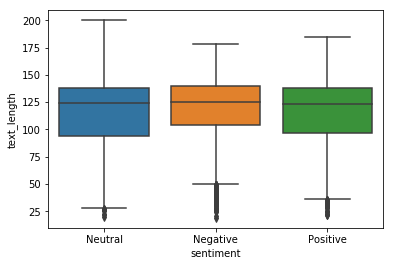

In [12]:
sns.boxplot(x='sentiment', y='text_length', data=data)

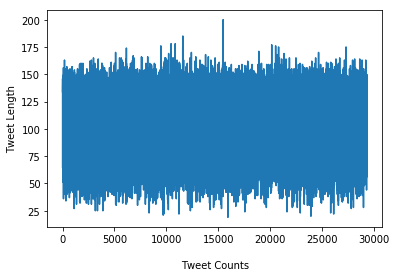

In [13]:
plt.plot(np.arange(1,len(data)+1),data['text_length'])
plt.ylabel("Tweet Length")
plt.xlabel("\nTweet Counts")
plt.show()

### How many of them?

In [14]:
print('\033[1m' + str(sum(data['text_length']>140)) + '\033[0m')  

2712


# PreProcessing

In [936]:
naivebayes.train= pd.read_csv('trainDataOld.csv',sep='\t')
naivebayes.test = pd.read_csv('testDataOld.csv' ,sep='\t')

naivebayes.preProcessing()
#naivebayes.align()

In [1]:
print('\033[1m' + ' Now: ' + '\033[0m', sum((naivebayes.train['processed_text'].apply(lambda x: len(x)))>140)+sum((naivebayes.test['processed_text'].apply(lambda x: len(x)))>140))  

NameError: name 'naivebayes' is not defined

In [ ]:
#Words with negation

In [31]:
msk=naivebayes.train['processed_text'].apply(lambda x: "n't" in x or "not" in x or "no" in x)
len(naivebayes.train[msk])

7232

In [43]:
list(naivebayes.train[msk]['text'])

["RT @Politicolnews: I think it's time to start calling the Democrats offices, demand they use the 14th now, don't cave to Nut Jobs.",
 "@DocThompsonShow @skiplacombe Did you see Bobby Jindal's comments on Westborough Church? No respect for 1st amendment maybe #notthatguy",
 'RT @NerdyNegress: #GOPdebates\nThis is No damn Christian revival. Cut it out.',
 "RT @kayski: They gave more time to God than they did about race relations. I don't know how to take any of these candidates seriously #GOPD…",
 "RT @RWSurferGirl: The candidates don't have to attack @realDonaldTrump Fox is doing it for them by stoping him from speaking. 🇺🇸 #GOPDebate…",
 "Trump disagreeing with Megyn Kelly's pointed, somewhat gotcha questions does not equate to her being a bimbo. &lt;sigh&gt; #gopdebate",
 'RT @BNLieb: By smearing opponents of #WhiteGenocide as “Nazis” Libzis perverted the #MemoryOfTheHolocaust into a weapon to GUARANTEE genoci…',
 'RT @RWSurferGirl: It is very disappointing that Fox News is not cond

In [44]:
list(naivebayes.train[msk]['processed_text'])

["i think it's time to start calling the democrats offices demand they use the th now don't cave to nut jobs",
 "did you see bobby jindal's comments on westborough church no respect for st amendment maybe notthatguy",
 'gopdebates this is no damn christian revival cut it out',
 "they gave more time to god than they did about race relations i don't know how to take any of these candidates seriously gopd…",
 "the candidates don't have to attack fox is doing it for them by stoping him from speaking  gopdebate…",
 "trump disagreeing with megyn kelly's pointed somewhat gotcha questions does not equate to her being a bimbo sigh gopdebate",
 'by smearing opponents of whitegenocide as nazis” libzis perverted the memoryoftheholocaust into a weapon to guarantee genoci…',
 'it is very disappointing that fox news is not conducting a fair balanced debate  gopdebate gopdebates',
 'definitely noticed definitely not appreciated definitely not acceptable gopdebate goptbt',
 'intelligence class and char

In [51]:
tk=nltk.casual.TweetTokenizer()
list(naivebayes.train[msk]['processed_text'].apply(lambda x: nltk.pos_tag(tk.tokenize(x))))

[[('i', 'NN'),
  ('think', 'VBP'),
  ("it's", 'JJ'),
  ('time', 'NN'),
  ('to', 'TO'),
  ('start', 'VB'),
  ('calling', 'VBG'),
  ('the', 'DT'),
  ('democrats', 'NNPS'),
  ('offices', 'NNS'),
  ('demand', 'VBP'),
  ('they', 'PRP'),
  ('use', 'VBP'),
  ('the', 'DT'),
  ('th', 'NN'),
  ('now', 'RB'),
  ("don't", 'VBZ'),
  ('cave', 'VB'),
  ('to', 'TO'),
  ('nut', 'VB'),
  ('jobs', 'NNS')],
 [('did', 'VBD'),
  ('you', 'PRP'),
  ('see', 'VB'),
  ('bobby', 'JJ'),
  ("jindal's", 'NN'),
  ('comments', 'NNS'),
  ('on', 'IN'),
  ('westborough', 'IN'),
  ('church', 'NN'),
  ('no', 'DT'),
  ('respect', 'NN'),
  ('for', 'IN'),
  ('st', 'JJ'),
  ('amendment', 'NN'),
  ('maybe', 'RB'),
  ('notthatguy', 'RB')],
 [('gopdebates', 'NNS'),
  ('this', 'DT'),
  ('is', 'VBZ'),
  ('no', 'DT'),
  ('damn', 'NN'),
  ('christian', 'JJ'),
  ('revival', 'NN'),
  ('cut', 'VBD'),
  ('it', 'PRP'),
  ('out', 'RP')],
 [('they', 'PRP'),
  ('gave', 'VBD'),
  ('more', 'JJR'),
  ('time', 'NN'),
  ('to', 'TO'),
  ('god', 'V

In [660]:
#Xth Xst Xnd Xrd 
tx='fight for zong 94th 22nd 2nd 1st 3rd dde'
tweet=re.sub(r'[0-9]+(th|nd|st|rd)','',tweet)

'fight for zong      dde'

In [603]:
list(naivebayes.train['text'])

["@DocThompsonShow @skiplacombe Did you see Bobby Jindal's comments on Westborough Church? No respect for 1st amendment maybe #notthatguy",
 "RT @RWSurferGirl: FOX News won't admit who the Republican leader is right now I mean @realDonaldTrump only has a double-digit lead 🇺🇸 #GOPD…",
 'RT @SalMasekela: Senator Cruz, any word from God? Just spit out my tequila. Damn you Megyn Kelly, it was the expensive kind. #GOPDebates',
 '.@seanspicer looks like he has a broom handle 1 foot up his ass talking to @andersoncooper on @cnn #GOPdebates',
 "RT @mandy_velez: So trans soldiers can die for you Huckabee but you can't foot the bill to make them fulfilled as human beings? Really? #GO…",
 "Why oh why does Toronto's Nuit Blanche have to be the same night as a wedding I have to attend?!? #snbTO",
 'RT @RWSurferGirl: It is very disappointing that Fox News is not conducting a "Fair &amp; Balanced" Debate. 🇺🇸 #GOPDebate  #GOPDebates',
 'RT @JeffersonObama: The President trolling Cruz during debate #GO

In [668]:
list(naivebayes.train['processed_text'])

["did you see bobby jindal's comments on westborough church no respect for amendment maybe notthatguy",
 "fox news won't admit who the republican leader is right now i mean only has a doubledigit lead 🇺 🇸 gopd …",
 'senator cruz any word from god just spit out my tequila damn you megyn kelly it was the expensive kind gopdebates',
 'looks like he has a broom handle foot up his ass talking to on gopdebates',
 "so trans soldiers can die for you huckabee but you can't foot the bill to make them fulfilled as human beings really go …",
 "why oh why does toronto's nuit blanche have to be the same night as a wedding i have to attend snbto",
 'it is very disappointing that fox news is not conducting a fair balanced debate 🇺 🇸 gopdebate gopdebates',
 'the president trolling cruz during debate gopdebate',
 'shammi kapoor funeral on monday as tirbutes pour in channel newsasia known as the elvis presley elvispresley',
 "gopdebates questions are worded like personal attacks including half truths the

# Vocabulary Size

In [341]:
vect=CountVectorizer()
vect=vect.fit_transform(naivebayes.train['processed_text'])

In [342]:
(naivebayes.train['processed_text']).shape

(23469,)

In [343]:
print ("vocab size : ",vect.shape[1])

vocab size :  26491


# Base Line

In [254]:
naivebayes.train_classifier()
y_pred = naivebayes.predict()

In [255]:
printings()



Accuracy Score: 61.72%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_Negative  predicted_Neutral  predicted_Positive
Negative                1657                277                 221
Neutral                  538                857                 545
Positive                 293                372                1107
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   Negative    0.66600   0.76891   0.71376      2155
    Neutral    0.56906   0.44175   0.49739      1940
   Positive    0.59103   0.62472   0.60741      1772

avg / total    0.61130   0.61718   0.61009      5867



### Removing Custom Stop Words

In [264]:
_stopWords= getCustomStopWords()

In [265]:
naivebayes.train_classifier(stopwords=set(_stopWords))
y_pred = naivebayes.predict()

In [266]:
printings()



Accuracy Score: 62.86%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_Negative  predicted_Neutral  predicted_Positive
Negative                1683                283                 189
Neutral                  520                898                 522
Positive                 330                335                1107
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   Negative    0.66443   0.78097   0.71800      2155
    Neutral    0.59235   0.46289   0.51968      1940
   Positive    0.60891   0.62472   0.61671      1772

avg / total    0.62383   0.62860   0.62183      5867



# Bigrams

In [267]:
naivebayes.train_classifier(ngramRng=(1,2))
y_pred = naivebayes.predict()

In [268]:
printings()



Accuracy Score: 64.02%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_Negative  predicted_Neutral  predicted_Positive
Negative                1610                335                 210
Neutral                  418                973                 549
Positive                 227                372                1173
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   Negative    0.71397   0.74710   0.73016      2155
    Neutral    0.57917   0.50155   0.53757      1940
   Positive    0.60714   0.66196   0.63337      1772

avg / total    0.63713   0.64019   0.63724      5867



## Removing Custom stopwords

In [269]:
_stopWords= getCustomStopWords()

In [270]:
naivebayes.train_classifier(stopwords=set(_stopWords),ngramRng=(1,2))
y_pred = naivebayes.predict()

In [271]:
printings()



Accuracy Score: 63.70%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_Negative  predicted_Neutral  predicted_Positive
Negative                1605                322                 228
Neutral                  438                962                 540
Positive                 241                361                1170
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   Negative    0.70271   0.74478   0.72314      2155
    Neutral    0.58480   0.49588   0.53668      1940
   Positive    0.60372   0.66027   0.63073      1772

avg / total    0.63382   0.63695   0.63357      5867



# Trigrams

In [272]:
naivebayes.train_classifier(ngramRng=(1,3))
y_pred = naivebayes.predict()

In [273]:
printings()



Accuracy Score: 63.44%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_Negative  predicted_Neutral  predicted_Positive
Negative                1509                402                 244
Neutral                  358               1010                 572
Positive                 194                375                1203
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   Negative    0.73217   0.70023   0.71584      2155
    Neutral    0.56519   0.52062   0.54199      1940
   Positive    0.59584   0.67889   0.63466      1772

avg / total    0.63578   0.63440   0.63384      5867



### Removing Custom stopwords

In [274]:
_stopWords= getCustomStopWords()

In [275]:
naivebayes.train_classifier(stopwords=set(_stopWords),ngramRng=(1,3))
y_pred = naivebayes.predict()

In [276]:
printings()



Accuracy Score: 63.35%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_Negative  predicted_Neutral  predicted_Positive
Negative                1536                374                 245
Neutral                  398                983                 559
Positive                 202                372                1198
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   Negative    0.71910   0.71276   0.71592      2155
    Neutral    0.56854   0.50670   0.53584      1940
   Positive    0.59840   0.67607   0.63487      1772

avg / total    0.63286   0.63354   0.63189      5867



# TF IDF on TriGram

In [295]:
naivebayes.train_classifier(ngramRng=(1,2),vectorizer=TfidfVectorizer())
y_pred = naivebayes.predict()

In [937]:
#_stopWords= getCustomStopWords2()
#stopwords=set(['the','once'])   0.64451

stopWordsCustom=['its',
 'am',
 'having',
 'when',
 'himself',
 'ma',
 'does',
 'd',
 'in',
 'doing',
 're',
 'can',
 'once',
 'myself',
 'more',
 'while',
 'other',
 'such',
 'few',
 'most',
 'any',
 'he',
 'until',
 'into',
 'o',
 'during',
 'below',
 'both']

naivebayes.train_classifier(stopwords=set(stopWordsCustom),mindif=3,ngramRng=(1,5),vectorizer=TfidfVectorizer())
y_pred = naivebayes.predict()

In [938]:
printings()



Accuracy Score: 64.38%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_Negative  predicted_Neutral  predicted_Positive
Negative                1547                394                 214
Neutral                  393               1117                 430
Positive                 186                473                1113
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   Negative    0.72766   0.71787   0.72273      2155
    Neutral    0.56300   0.57577   0.56932      1940
   Positive    0.63347   0.62810   0.63077      1772

avg / total    0.64476   0.64377   0.64423      5867



In [894]:
#print ("mai hogyi: ", oldValue)

0.6422228959211087
0.6422739752568238
0.6426243125915135
0.6431078267733048
0.6432652447446404
0.6434401186232587
0.6436495452444984
0.6436650187395063
0.6447401995440353
0.6448976308143188
0.6450640114730394
0.6451575640455012
0.6453262266471383
0.6453701666463113
0.6457190890835005
0.6460392292782999
0.6463883308456043
0.6463943125329684
0.6466922313152074
0.6470192004795118
0.6471961200609817
0.6472833933043252
0.647647130375626
0.6479764670963167
0.6479794586556106
0.6483236804637889
0.6484984514119619
0.6485221115301196


In [907]:
y_pred

array(['Negative', 'Negative', 'Negative', ..., 'Neutral', 'Positive',
       'Positive'], dtype='<U8')

In [912]:
len(naivebayes.test)

5867

In [931]:
list(naivebayes.test[~(naivebayes.test['sentiment']==y_pred)]['sentiment'])

['Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',

In [914]:
list(naivebayes.test[~(naivebayes.test['sentiment']==y_pred)]['text'])

["The ONE time we want to use the Amazon Prime streaming and it's down... grrr ruined my Sunday night! @AmazonUK",
 'RT @BettyBowers: Asking about God violates  Article VI, paragraph 3 of the Constitution: "There will be no religious test for office." #GOP…',
 'I have till Thursday to know every damn word to every damn song Eric church is going to sing',
 'Shout out to Bernie Sanders for slipping under the radar of these democrat jokes #GOPDebates',
 'My dad & the builder are talking about City and it turns out the builder is sat the row behind me at the Aston Villa game\\u002c fuck sake',
 'I noticed all the Huddlestone haters were conspicuous by their absence yesterday\\u002c particularly when he assisted Bale for the 1st goal #THFC',
 'Kinda sucks\\u002c he missed my classes graduation over something he may or may not have done',
 'The night #JohnStewart signed off from #TDS he killed 2 birds with one stone: #GOPDebate on #FoxDebate . No need to further comment on them',
 "@vlanda W

In [915]:
list(naivebayes.test[~(naivebayes.test['sentiment']==y_pred)]['processed_text'])

['the one time we want to use the amazon prime streaming and it is down grr ruined my sunday night',
 'asking about god violates article vi paragraph of the constitution there will be  irreligious test for office gop …',
 'i have till thursday to know every damn word to every damn song eric church is going to sing',
 'shout out to bernie sanders for slipping under the radar of these democrat jokes gopdebates',
 'my dad the builder are talking about city and it turns out the builder is sat the row behind me at the aston villa game fuck sake',
 'i noticed all the huddlestone haters were conspicuous by their absence yesterday particularly when he assisted bale for the goal thfc',
 'kinda sucks he missed my classes graduation over something he may or may not have done',
 'the night johnstewart signed off from tds he killed birds with one stone gopdebate on foxdebate no need to further comment on them',
 'who is the real illegal alien gopdebate farrakhan on immigration the mexican bor via',

In [887]:
li.append('are')

['sasdsad', 'sdasd']

# Stats For Saved Split 

In [54]:
0.63574  tfidf uni bi 
0.63609  tfidf uni bi     - with negation
0.63641  tfidf uni bi tri - with negation

  tfidf uni bi tri - with negation - custom stop words removal



Humari:

0.63574  tfidf uni bi 
0.63613  tfidf uni bi     - with negation
0.63717  tfidf uni bi     - with negation - with that negation word removal
0.63776  tfidf uni bi     - with negation - with that negation word removal - mindf 2 - antonym

0.63676  tfidf uni bi tri - with negation
0.63694  tfidf uni bi tri - with negation - with that negation word removal
0.63755  tfidf uni bi tri - with negation - with that negation word removal - mindf 4
0.63769  tfidf uni bi tri - with negation - with that negation word removal - mindf 3 - antonym

0.63978  tfidf uni bi tri quad - with negation - with that negation word removal - mindf 3
0.64031  tfidf uni bi tri quad - with negation - with that negation word removal - mindf 3 - antonym
0.64105  tfidf uni bi tri quad - with negation - with that negation word removal - mindf 3 - antonym - acronym
0.64154  tfidf uni bi tri quad - with negation - with that negation word removal - mindf 3 - antonym - acronym - with emojis

0.64231  tfidf uni bi tri quad - with negation - with that negation word removal - mindf 3 - antonym - acronym - with emojis - 'st/nd..' removed

0.64191  tfidf uni bi tri quad five - with negation - with that negation word removal - mindf 3 - antonym - acronym - with emojis

         



# Require: doc

# doc: given document 
# flag = false 
# for w in doc do:
# if w = ”not” or ”n’t” or ”no” then flag= not flag
# continue
# end if
# if
#   flag= True then
#   if w= Adjective or Verb or Noun then
#      Add ”not ”+ w to feature set of opposite class
#      end if
#   if (w= Adverb or Determiner) and nextw= Adjective then
#      Add ”not ”+ nextw to feature set of opposite class
#      end if
#   if w= Determiner and nextw= Adverb and nextnextw = Adjective then
#      Add ”not ”+ nextnextw to feature set of opposite class
#      end if
#      flag= false
#   end if 
#
#
#end for

'not_doc[i]'

In [15]:
('oyesters', 'NNS')[1]

'NNS'

In [11]:
tk.tokenize('oyesters eat fish')

['oyesters', 'eat', 'fish']

In [13]:
a=[1,2,3]
b=[4,2,3]
for w,c in zip(a,b):
    print (w,c)
    w=3
a

1 4
2 2
3 3


[1, 2, 3]

In [14]:
b

[4, 2, 3]

In [323]:
naivebayes.train['processed_text'][9]

"gopdebates democrats can't even find one good candidate truthbomb"

In [324]:
nltk.pos_tag(naivebayes.train['processed_text'][9].split())

[('gopdebates', 'NNS'),
 ('democrats', 'VBP'),
 ("can't", 'VBP'),
 ('even', 'RB'),
 ('find', 'VB'),
 ('one', 'CD'),
 ('good', 'JJ'),
 ('candidate', 'NN'),
 ('truthbomb', 'NN')]

In [126]:
a="I haven't done it"
arr=a.split()
for i in range(0,len(arr)):
    if("n't" in arr[i])==True:
        arr[i]=''
b=' '.join(arr)
tk=nltk.casual.TweetTokenizer()   

In [127]:
tk.tokenize(b)

['I', 'done', 'it']

In [402]:


getAntonym('ok')

'disapprove'

In [386]:
antonym

'evil'

In [543]:
tweet=re.sub(r'#[a-z0-9]*','',tweet)

NameError: name 'tweet' is not defined

In [692]:
c=np.unique(naivebayes.test['sentiment'])
b=[]
for a in c:
    b.append(np.sum(naivebayes.test['sentiment']==a))
print (c)
print (b)

['Negative' 'Neutral' 'Positive']
[2155, 1940, 1772]


In [839]:
printings()



Accuracy Score: 64.33%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_Negative  predicted_Neutral  predicted_Positive
Negative                1547                399                 209
Neutral                  390               1118                 432
Positive                 192                471                1109
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   Negative    0.72663   0.71787   0.72222      2155
    Neutral    0.56237   0.57629   0.56925      1940
   Positive    0.63371   0.62585   0.62976      1772

avg / total    0.64425   0.64326   0.64371      5867



In [955]:
def generate_folds(X, Y, nfolds=4):
    """
    Split the training data into startified-nfolds... 
    
    Parameters:
    --------
    X: training examples
    Y: training labels
    nfolds: number of folds...
        By default split according to fix 75-25% ratio
    
    Returns:
    ---------
    list of lists, with each nested list containing four elements
    training data, training labels, test data, test labels per fold
    """
    classes = np.unique(Y)
    print ('Generating CV data for {} classes'.format(len(classes)))
    
    cvlist = []  # four elements per nested-list
    # idxlist=[] # 2 elements per list to contain indeces...
    
    for cidx, c in enumerate(classes):
        idx = Y == c  # find class example indeces
        Yt = Y[idx]  # get class labels
        Xt = X[idx, :]  # get training examples
        nexamples = Xt.shape[0]
        # Generate a random permutation of the indeces
        ridx = np.arange(nexamples)  # generate indeces
        np.random.shuffle(ridx)  # shuffle randomly ...

        # number of test examples per fold
        nexamples = int(nexamples / nfolds)
        sridx = set(ridx)  # create a set of all indeces
        
        
        sidx = 0
        for k in range(nfolds):

            testidx = ridx[sidx:sidx + nexamples]
            trainidx = list(sridx.difference(testidx)) 
            sidx += nexamples
            
            if cidx == 0:
                cvlist.append([Xt[trainidx, :], Yt[trainidx], Xt[testidx, :], Yt[testidx]])
            else:  
                cvlist[k][0] = np.vstack((cvlist[k][0], Xt[trainidx, :]))
                cvlist[k][1] = np.hstack((cvlist[k][1], Yt[trainidx]))
                cvlist[k][2] = np.vstack((cvlist[k][2], Xt[testidx, :]))
                cvlist[k][3] = np.hstack((cvlist[k][3], Yt[testidx]))

    return cvlist





# Now lets cross validate for best paramters, and test the result...
# We will be training four different models on four different partitions of data set and 
# then will be reporting the mean accuracy of the four classifiers.

nfolds=10 # lets use four folds..
folds=generate_folds(Xdata,Ydata,nfolds)
features=[0,1, 2, 3] # features to use for our system
#now lets train and test on these folds...
purity=np.linspace(0.85,0.97,13) # You can also search over depth as well....
nexamp=np.linspace(5,25,21)  
foldacc=[]

   
totacc = []
for f in range(nfolds):

        
            train=pd.DataFrame(folds[f][0],columns=['text'])
            train['sentiment']=folds[f][1]
            naivebayes.train=train

            test=pd.DataFrame(folds[f][2],columns=['text'])
            test['sentiment']=folds[f][3]
            naivebayes.test=test

            naivebayes.preProcessing()


            naivebayes.train_classifier(stopwords=set(stopWordsCustom),mindif=3,ngramRng=(1,5),vectorizer=TfidfVectorizer())
            y_pred = naivebayes.predict()

            f1score = report_to_df(classification_report(naivebayes.testLabels(), y_pred,digits=20))['f1-score']['avg/total']
            print ("[Fold {} ] F1 Score = {}".format(f+1, f1score))
            totacc.append(f1score)


foldacc.append(np.mean(totacc))
print ("Mean F1 = ", np.mean(totacc))

Generating CV data for 3 classes
(26403, 1)


KeyboardInterrupt: 

In [953]:
naivebayes.t_data=naivebayes.t_data.drop_duplicates(subset='tweet_id')
naivebayes.t_data=naivebayes.t_data[~naivebayes.t_data['text'].apply(lambda x: (('neutral' in x) or ('positive' in x) or ('negative' in x)) and (len(x) > 140) )]
Xdata=np.asarray(naivebayes.t_data[['text']])
Ydata=np.asarray(naivebayes.t_data['sentiment'])


In [917]:
class okay:
    def sd():
        print('ok')
obj=okay()

In [918]:
obj.train=3

In [919]:
obj.train

3